# Predict Churn

In [ ]:
%matplotlib inline
import composeml as cp
import pandas as pd

## Load Data

In [2]:
PARTITION = '100'
BASE_DIR = 's3://customer-churn-spark/'
PARTITION_DIR = BASE_DIR + 'p' + PARTITION
transactions = f'{PARTITION_DIR}/transactions.csv'

In [3]:
transactions = pd.read_csv(
    transactions,
    parse_dates=['transaction_date', 'membership_expire_date'],
    infer_datetime_format=True,
)

transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,G7TmHc9Gg2t8ovG/KFaB53We/0CQPELhZ5UUN2Ol3AQ=,39,30,149,149,1,2015-09-30,2015-11-13,0
1,LPbp8N7VRuqEISEVim8ppTaeYJG/rWS/t4g/dEFuWjw=,34,30,149,149,1,2016-02-29,2016-03-31,0
2,xvYqULBWzJvN8heyFtY3hbY3egyQNbXuDx0igtsoi00=,29,30,180,180,1,2017-01-31,2017-03-01,0
3,UR4iin4mAkajoa7o+AyTTmz5k3N2GR3/rZY8a4KwADI=,41,30,99,99,1,2017-01-31,2017-02-28,0
4,ax8CRhY8BMRA/ZvT1wI+2N/EdPXiSPGxa9y7bntA1Uc=,40,30,149,149,1,2016-05-04,2016-06-08,0


## Generate Labels

### Create Times for Beginning of the Month

In [4]:
month_begin = pd.offsets.MonthBegin()
expire_date = transactions['membership_expire_date']
transactions['lead_time'] = expire_date.apply(month_begin.rollback)
transactions[['msno', 'lead_time', 'membership_expire_date']].head()

,msno,lead_time,membership_expire_date
0,G7TmHc9Gg2t8ovG/KFaB53We/0CQPELhZ5UUN2Ol3AQ=,2015-11-01,2015-11-13
1,LPbp8N7VRuqEISEVim8ppTaeYJG/rWS/t4g/dEFuWjw=,2016-03-01,2016-03-31
2,xvYqULBWzJvN8heyFtY3hbY3egyQNbXuDx0igtsoi00=,2017-03-01,2017-03-01
3,UR4iin4mAkajoa7o+AyTTmz5k3N2GR3/rZY8a4KwADI=,2017-02-01,2017-02-28
4,ax8CRhY8BMRA/ZvT1wI+2N/EdPXiSPGxa9y7bntA1Uc=,2016-06-01,2016-06-08


### Create Labeling Function

In [5]:
def inactive_membership(transactions, window):  
    if len(transactions) == 1:
        cutoff_time, end_time = window
        elapsed_inactive = end_time - transactions['membership_expire_date'].iloc[0]
        return elapsed_inactive
    
    transactions = transactions.sort_values('transaction_date')
    membership_expire_date = transactions['membership_expire_date'].iloc[0]
    next_transaction_date = transactions['transaction_date'].iloc[1]
    elapsed_inactive = next_transaction_date - membership_expire_date

    return elapsed_inactive

### Construct Label Maker

In [6]:
label_maker = cp.LabelMaker(
    target_entity='msno',
    time_index='lead_time',
    labeling_function=inactive_membership,
    window_size='100d',
)

### Search Labels

In [7]:
label_times = label_maker.search(
    transactions,
    minimum_data=0,
    num_examples_per_instance=2,
    gap=1,
    verbose=True,
)

label_times.head()

Elapsed: 00:31 | Remaining: 00:00 | Progress: 100%|██████████| msno: 4978/4978 


,msno,cutoff_time,inactive_membership
label_id,,,
0,+/6nRSzfF+CIynhnBM5xz8J6ArlSdLY74gsNK09dbes=,2015-06-01,86 days
1,+1TKL6EWVDuKFAOvWZOsoGTILy2POMnxxvUgP7PPCy8=,2016-11-01,80 days
2,+58aOzMPOZSi0END5IUKzK009k/iGY9mB+k9s5qetAI=,2016-11-01,86 days
3,+6UN6VJD8u9vZm4lZRAREpzBRM4YoeOSWhEX0c5JBAU=,2016-09-01,76 days
4,+6UN6VJD8u9vZm4lZRAREpzBRM4YoeOSWhEX0c5JBAU=,2017-01-01,4 days


### Bin Labels

In [8]:
edge_min = label_times.inactive_membership.min()
zero, one_month = pd.Timedelta('0d'), pd.Timedelta('31d')
edge_max = label_times.inactive_membership.max()
bins = [edge_min, zero, one_month, edge_max]

labels = ['active', 'inactive', 'churn']
labels = label_times.bin(bins, labels=labels)

labels.head()

,msno,cutoff_time,inactive_membership
label_id,,,
0,+/6nRSzfF+CIynhnBM5xz8J6ArlSdLY74gsNK09dbes=,2015-06-01,churn
1,+1TKL6EWVDuKFAOvWZOsoGTILy2POMnxxvUgP7PPCy8=,2016-11-01,churn
2,+58aOzMPOZSi0END5IUKzK009k/iGY9mB+k9s5qetAI=,2016-11-01,churn
3,+6UN6VJD8u9vZm4lZRAREpzBRM4YoeOSWhEX0c5JBAU=,2016-09-01,churn
4,+6UN6VJD8u9vZm4lZRAREpzBRM4YoeOSWhEX0c5JBAU=,2017-01-01,inactive


### Describe Labels

Label Distribution
------------------
active      2257
churn       1198
inactive     623
Total:      4078


Settings
--------
num_examples_per_instance       2
minimum_data                    0
window_size                  100d
gap                             1


Transforms
----------
1. bin
  - bins:         [-477 days +00:00:00, 0 days 00:00:00, 31 days...
  - quantiles:                                                False
  - labels:                               [active, inactive, churn]
  - right:                                                     True



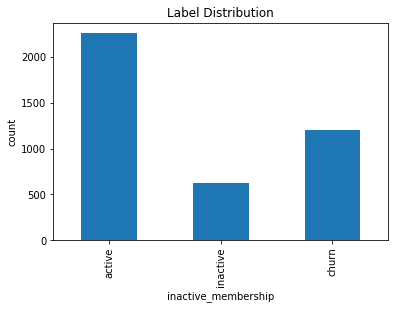

In [9]:
labels.describe()
labels.plot.distribution();